In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np

file_path = './test_files/3Dblood27.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.300000,11.197390,3.047941,0,0,0
1,4.200000,11.197390,3.047941,0,0,0
2,4.100000,11.197390,3.047941,0,0,0
3,4.000000,11.197390,3.047941,0,0,0
4,3.900000,11.197390,3.047941,0,0,0
...,...,...,...,...,...,...
1799,4.324351,10.356519,3.886832,255,0,255
1800,4.253031,10.706822,3.538061,255,0,255
1801,4.260648,10.636221,3.608462,255,0,255
1802,4.295052,11.128907,3.116422,255,0,255


In [21]:
def distance_calculator(df):
    # Drop NaN values (usually the first value)
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removes the jump and makes the line continuous
    # Note this seems very fragile and I probably need add a second check for large jumps at the end of the code
    if shape.iloc[-1]['distance_from_last'] > 1.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

def midlinejumpsplitter(shape):
    # Split lines that have big jumps in the middle
    # Need to assign line id in a separate function
    if shape['distance_from_last'].max() > 1.:
        # Split the line at the index
        split_index = shape[shape['distance_from_last'] > 1.].index[0]
        shape1 = shape.iloc[:split_index]
        shape1['line_id'] = df['line_id'].unique()[-1] + 1
        shape2 = shape.iloc[split_index:]
        shape2['line_id'] = df['line_id'].unique()[-1] + 2
        df = pd.concat([df[df['line_id'] != 0], shape1, shape2]).reset_index(drop=True)
    return df

df = distance_calculator(df)
# Initially, identify distinct lines by their RGB values
df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)
df = distance_calculator(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan
df = df.groupby('line_id', group_keys=False).apply(midlinejumpsplitter)
df

# # Split lines that have big jumps in the middle
# shape = df[df['line_id'] == 4]
# shape.iloc[0]
# shape[shape['distance_from_last'] > 1.].index
# # Split the line at the index
# split_index = shape[shape['distance_from_last'] > 1.].index[0]
# shape1 = shape.iloc[:split_index]
# shape1['line_id'] = df['line_id'].unique()[-1] + 1
# shape2 = shape.iloc[split_index:]
# shape2['line_id'] = df['line_id'].unique()[-1] + 2
# df = pd.concat([df[df['line_id'] != 0], shape1, shape2]).reset_index(drop=True)
# df


UnboundLocalError: cannot access local variable 'df' where it is not associated with a value

In [44]:
# Next bit is to use hierarchical clustering to note common start / end points
# Gather the first and last points of each line:
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
start_points = df.groupby('line_id', group_keys=False).first()  # First point of each line
end_points = df.groupby('line_id', group_keys=False).last()  # Last
terminal_points = pd.concat([start_points, end_points])   
dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
link_mat = hier.linkage(dist_mat)
# fcluster assigns each of the particles in positions a cluster to which it belongs
cluster_idx = hier.fcluster(link_mat, t=1, criterion='distance')   # t defines the max cophonetic distance in a cluster
terminal_points['cluster'] = cluster_idx

# Calculate the cluster start and end points 

,x,y,z,r,g,b,distance_from_last,cluster
line_id,,,,,,,,
0,4.300000,11.197390,3.047941,0,0,0,0.100000,1
1,18.173898,11.206091,2.920448,0,255,0,4.326986,2
2,18.110164,11.386743,2.813780,0,127,0,13.813447,2
3,18.077385,11.126517,2.864335,0,255,255,13.778063,2
4,18.019722,11.206369,2.979489,255,0,0,13.719317,2
5,18.121304,10.986916,2.980895,255,255,0,13.703188,2
6,18.132802,11.296763,2.980130,255,127,0,13.744422,2
7,17.994121,11.205519,3.199386,0,0,255,13.625876,2
8,18.174472,11.022778,3.162338,255,0,255,13.802659,2


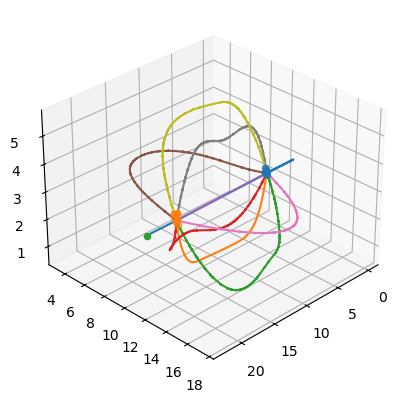

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in np.unique(df['line_id'].values):
    ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# If you need a specific line plotting
# n = 7
# ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

for n in np.unique(terminal_points['cluster'].values):
    ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

ax.view_init(elev=30, azim=45)  # Elevation of 30 degrees, azimuth of 45 degrees
plt.show()



In [12]:
df[df['line_id'] == 0]

,x,y,z,r,g,b,distance_from_last,line_id
0,4.275980,11.059498,3.185819,255,0,255,NaN,0
1,4.295052,11.128907,3.116422,255,0,255,0.099987,0
2,4.260648,10.636221,3.608462,255,0,255,0.697156,0
3,4.253031,10.706822,3.538061,255,0,255,0.099995,0
4,4.324351,10.356519,3.886832,255,0,255,0.499439,0
...,...,...,...,...,...,...,...,...
225,18.153788,10.878121,3.298834,255,0,255,0.099995,0
226,18.174472,11.022778,3.162338,255,0,255,0.199961,0
227,18.165722,10.950724,3.231118,255,0,255,0.099995,0
228,18.179940,11.094141,3.092508,255,0,255,0.199959,0


In [20]:
def determine_style(row):
    # capillaries
    if row['b'] > 0:
        return 2
    # venules
    elif row['g'] > 0:
        return 5
    # veins 
    elif row['r'] > 0:
        return 8 
    else:
        return 1

def thickness_to_radius(thickness):
    # Assuming radius is proportional to thickness
    return thickness / 2

# Apply determine_style to get thickness
df['thickness'] = df.apply(determine_style, axis=1)

# Convert thickness to radius3
df['radius'] = df['thickness'].apply(thickness_to_radius)

df['e'] = np.pi * df['radius']**2 * df['distance_to_next']

df

,x,y,z,r,g,b,distance_to_next,thickness,radius,e
0,0.900000,0.000000,0.0,200,0,0,NaN,8,4.0,NaN
1,1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
2,-0.900000,0.000000,0.0,200,0,0,1.900000,8,4.0,95.504417
3,-1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
4,0.639206,-0.316260,0.0,0,255,0,1.669435,5,2.5,32.779289
...,...,...,...,...,...,...,...,...,...,...
190,-0.087749,-0.012726,0.0,0,0,255,0.014130,2,1.0,0.044391
191,-0.100991,-0.006839,0.0,0,0,255,0.014491,2,1.0,0.045526
192,-0.114177,0.000032,0.0,0,0,255,0.014869,2,1.0,0.046712
193,-0.127244,0.007937,0.0,0,0,255,0.015272,2,1.0,0.047979


In [21]:
def generate_gcode(df):
    gcode_lines = []

    # Define some starting commands if necessary
    gcode_lines.append("G21 ; Set units to millimeters")
    gcode_lines.append("G90 ; Absolute positioning")
    
    for index, row in df.iterrows():
        # Move to the start position
        gcode_lines.append(f"G0 X{row['x']} Y{row['y']} Z{row['z']} ; Move to start position")
        
        # Example of drawing or other operation
        # For simplicity, let's assume 'e' is used for setting extrusion or other properties
        gcode_lines.append(f"G1 E{row['e']} ; Set extrusion amount")
        
        # Move to another position or perform an action (for demonstration)
        gcode_lines.append(f"G1 X{row['x']+5} Y{row['y']} Z{row['z']} ; Move to another position")
    
    # Add end commands if necessary
    gcode_lines.append("M30 ; End of program")

    return "\n".join(gcode_lines)

# Generate the G-code
gcode = generate_gcode(df)

# Save to a file
with open("output.gcode", "w") as file:
    file.write(gcode)